<a href="https://colab.research.google.com/github/hellocybernetics/Tensorflow-Probability-Tutorials/blob/master/edward2_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-probability

In [0]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style()

tfd = tfp.distributions
ed = tfp.edward2
tfe = tf.contrib.eager

In [0]:
def logistic_regression(features):
    """Bayesian logistic regression, which returns labels given features."""
    coeffs = ed.MultivariateNormalDiag(
        loc=tf.zeros(features.shape[1]), name="coeffs")
    labels = ed.Bernoulli(
        logits=tf.tensordot(features, coeffs, [[1], [0]]), name="labels")
    return labels


def covertype():
    """Builds the Covertype data set."""
    import sklearn.datasets  # pylint: disable=g-import-not-at-top
    data = sklearn.datasets.covtype.fetch_covtype()
    features = data.data
    labels = data.target

    # Normalize features and append a column of ones for the intercept.
    features -= features.mean(0)
    features /= features.std(0)
    features = np.hstack([features, np.ones([features.shape[0], 1])])
    features = tf.cast(features, dtype=tf.float32)

    # Binarize outcomes on whether it is a specific category.
    _, counts = np.unique(labels, return_counts=True)
    specific_category = np.argmax(counts)
    labels = (labels == specific_category)
    labels = tf.cast(labels, dtype=tf.int32)
    return features, labels


In [4]:
tf.enable_eager_execution()
print("Number of available GPUs", tfe.num_gpus())

features, labels = covertype()
print("Data set size", features.shape[0])
print("Number of features", features.shape[1])

log_joint = ed.make_log_joint_fn(logistic_regression)
def target_log_prob_fn(coeffs):
    return log_joint(features=features, coeffs=coeffs, labels=labels)

coeffs = tf.constant(
    [+2.03420663e+00, -3.53567265e-02, -1.49223924e-01, -3.07049364e-01,
     -1.00028366e-01, -1.46827862e-01, -1.64167881e-01, -4.20344204e-01,
     +9.47479829e-02, -1.12681836e-02, +2.64442056e-01, -1.22087866e-01,
     -6.00568838e-02, -3.79419506e-01, -1.06668741e-01, -2.97053963e-01,
     -2.05253899e-01, -4.69537191e-02, -2.78072730e-02, -1.43250525e-01,
     -6.77954629e-02, -4.34899796e-03, +5.90927452e-02, +7.23133609e-02,
     +1.38526391e-02, -1.24497898e-01, -1.50733739e-02, -2.68872194e-02,
     -1.80925727e-02, +3.47936489e-02, +4.03552800e-02, -9.98773426e-03,
     +6.20188080e-02, +1.15002751e-01, +1.32145107e-01, +2.69109547e-01,
     +2.45785132e-01, +1.19035013e-01, -2.59744357e-02, +9.94279515e-04,
     +3.39266285e-02, -1.44057125e-02, -6.95222765e-02, -7.52013028e-02,
     +1.21171586e-01, +2.29205526e-02, +1.47308692e-01, -8.34354162e-02,
     -9.34122875e-02, -2.97472421e-02, -3.03937674e-01, -1.70958012e-01,
     -1.59496680e-01, -1.88516974e-01, -1.20889175e+00])

# Initialize step size via result of 50 warmup steps from Stan.
step_size = 0.00167132

/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __p

Number of available GPUs 1
Data set size 581012
Number of features 55


In [0]:
coeffs_init = tf.random_normal([features.shape[1]])

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob_fn,
    num_leapfrog_steps=3,
    step_size=tf.Variable(step_size),
    step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy())

    
[
    [coeffs],
    kernel_results,
] = tfp.mcmc.sample_chain(
        num_results=1000,
        num_burnin_steps=200,
        current_state=[coeffs_init],
        parallel_iterations=200,
        kernel=hmc)



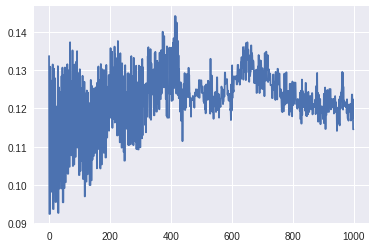

In [21]:
plt.plot(coeffs[:, 33].numpy())

In [0]:
coeff_mean = tf.reduce_mean(coeffs[800:], axis=0)

In [0]:
def logistic_predicor(features):
    coeff_mean = tf.reduce_mean(coeffs[800:], axis=0)
    return ed.Bernoulli(logits=tf.tensordot(features, coeff_mean, [[1], [0]]))

In [0]:
y = logistic_predicor(features)
accuracy = tf.reduce_mean(tf.cast(tf.equal(y, labels), dtype=tf.float32))

In [68]:
print(accuracy)

tf.Tensor(0.689552, shape=(), dtype=float32)
